In [9]:
!ls

KC_sandbox01.ipynb  sample_submission.csv  test.csv  train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

### Establish Data Fames

In [43]:
df_train = pd.read_csv(r'train.csv')
df_train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [44]:
df_train.drop('id', axis='columns', inplace=True)
df_train.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


In [45]:
df_test = pd.read_csv(r'test.csv')
df_test.drop('id', axis='columns', inplace=True)
df_test.head()

,gravity,ph,osmo,cond,urea,calc
0,1.017,5.24,345,11.5,152,1.16
1,1.020,5.68,874,29.0,385,3.46
2,1.024,5.36,698,19.5,354,13.00
3,1.020,5.33,668,25.3,252,3.46
4,1.011,5.87,567,29.0,457,2.36


## Visualise data

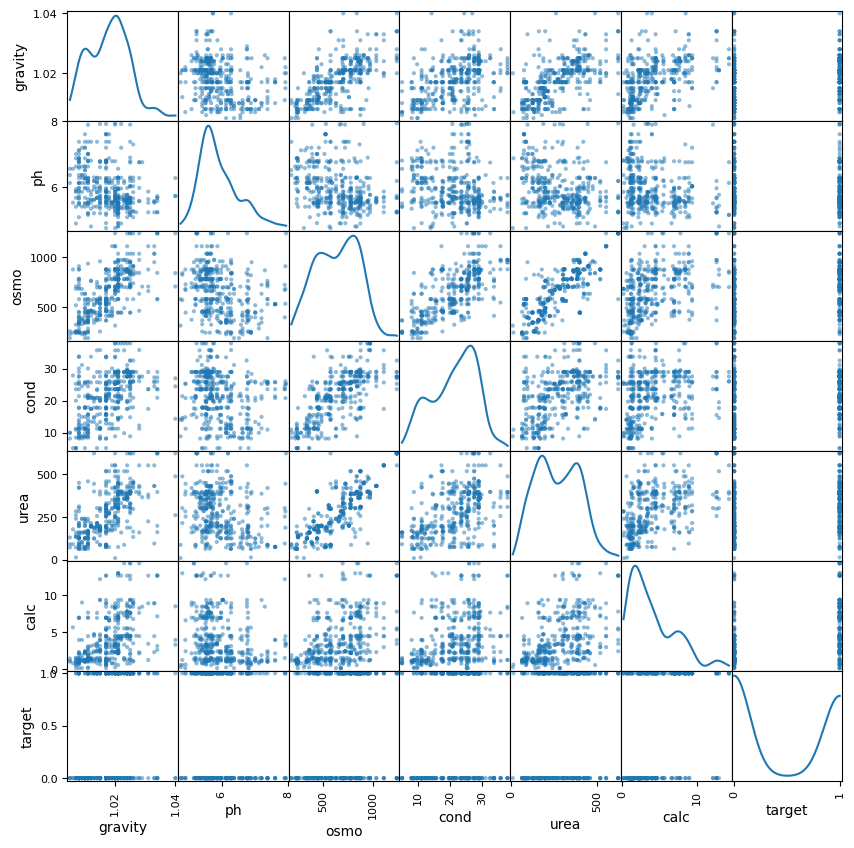

In [59]:
# Whole train set Scatter Matrix

pd.plotting.scatter_matrix(df_train, alpha=.5, diagonal='kde', figsize=(10,10));

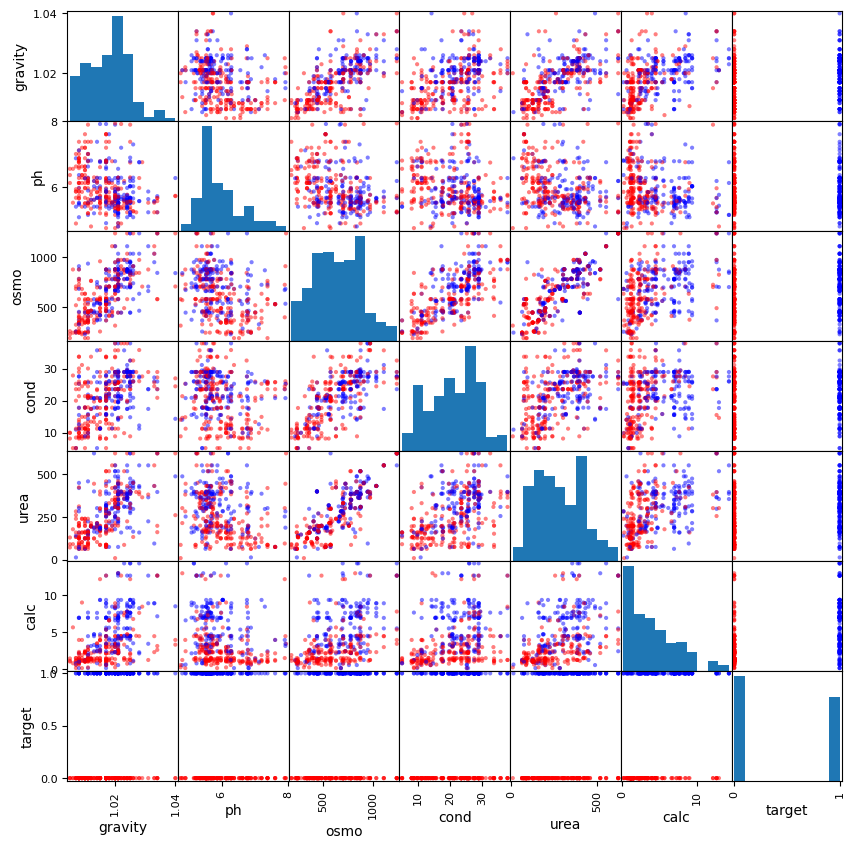

In [65]:
colors = ['blue' if x == 1 else 'red' for x in df_train['target']]
pd.plotting.scatter_matrix(df_train,alpha=.5,figsize=(10,10), color=colors);

#### Next steps: separate pop into 1/0, plot

In [50]:
# signal portion of df_train
df_train_signal = df_train[df_train['target']==1]

# background portion of df_train
df_train_background = df_train[df_train['target']==0]


In [51]:
df_train_signal.head()

,gravity,ph,osmo,cond,urea,calc,target
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1
5,1.025,6.90,947,28.4,395,2.64,1
6,1.008,5.09,371,15.5,159,2.17,1
9,1.017,6.61,527,20.0,75,4.49,1


In [52]:
df_train_background.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
7,1.015,5.53,450,8.1,170,1.16,0
8,1.025,7.38,736,25.3,418,1.52,0


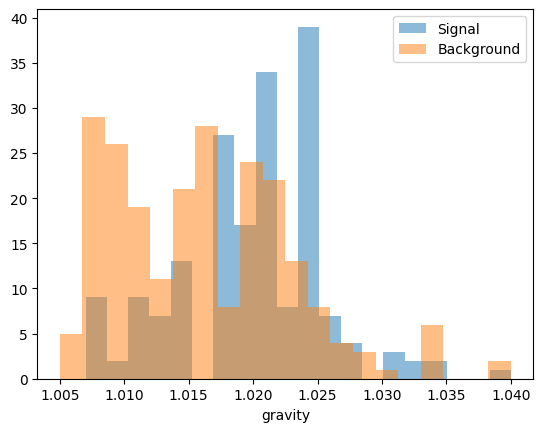

In [74]:
# establish order & names of columns
columns = ['gravity','ph','osmo','cond','urea','calc','target']

plt.hist(df_train_signal[columns[0]], bins=20, alpha=0.5, label='Signal')
plt.hist(df_train_background[columns[0]], bins=20, alpha=0.5, label='Background')
plt.legend()
plt.xlabel(columns[0])
plt.show()

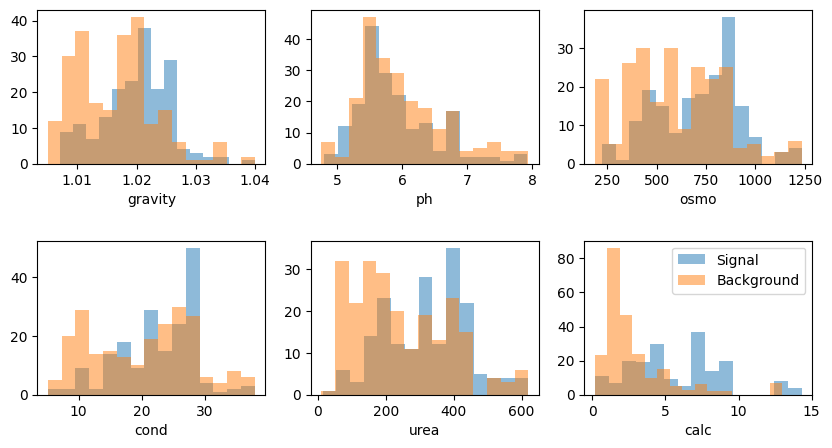

In [80]:
fig = plt.subplots(2, 3, figsize=(10,5))

for _ in range(0,6):
    plt.subplot(2, 3, _+1)
    plt.hist(df_train_signal[columns[_]], bins=15, alpha=0.5, label='Signal')
    plt.hist(df_train_background[columns[_]], bins=15, alpha=0.5, label='Background')
    plt.xlabel(columns[_])
    
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:

#sep train data to reserve for benchmark testing
#keep traack of mean & std used to normalize data. for consistency
#select machine learning alg's. try several
#ROC curve for ea.

In [40]:
desc = train.describe().T
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isna().sum()
desc['type'] = train.dtypes
desc

,count,mean,std,min,25%,50%,75%,max,nunique,%unique,null,type
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04,28,6.763285,0,float64
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94,71,17.149758,0,float64
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00,80,19.323671,0,int64
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00,65,15.700483,0,float64
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00,73,17.632850,0,int64
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34,85,20.531401,0,float64
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00,2,0.483092,0,int64
